<a href="https://colab.research.google.com/github/grasp-lyrl/picture_of_space_of_tasks/blob/main/tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview

Numerous algorithms---for transfer, few-shot, multi-task or continual learning---are able to successfully leverage data from multiple tasks. But why is this possible? What is the structure in data that allows us to learn from different tasks? To answer this question, we develop tools to analyze the geometry of representations learned on different tasks. We discuss some of these tools from https://arxiv.org/abs/2210.17011 in this notebook. 


Let's start by importing libraries and defining some helper functions.

In [ ]:
#@title Imports
import torch
import pickle
import random
import numpy as np
import torchvision
import pandas as pd

import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import plotly.graph_objects as go

from scipy import optimize
from functools import partial
from sklearn.decomposition import PCA

from torch.utils.data import Dataset, DataLoader
from typing import List
from torch import Tensor

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import to_rgb, to_hex


plt.style.use('seaborn-v0_8-whitegrid')

sns.set(context='poster',
        style='ticks',
        font_scale=0.65,
        rc={'axes.grid':True,
            'grid.color':'.9',
            'grid.linewidth':0.75})

In [ ]:
#@title Data
def cifar_transform():
    mean = (0.4914, 0.4822, 0.4465)
    std = (0.2471, 0.2435, 0.2616)

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])
    return transform


def get_task_dataloader(task):
    """
    Get the dataloaders of all even classes and all odd classes
    """
    dataset = torchvision.datasets.CIFAR100(
        root='./data', train=True, download=False, transform=cifar_transform())
    
    idx = np.where(np.array(dataset.targets) % 2 == task)[0]
    dataset.data = dataset.data[idx]
    dataset.targets = [int(x) for x in (np.array(dataset.targets)[idx] / 2)]

    loader = torch.utils.data.DataLoader(
        dataset, batch_size=64, shuffle=True, num_workers=2)
        
    return loader
    
        
def get_cifar_dataloader():
    dataset = torchvision.datasets.CIFAR100(
        root='./data', train=True,
        download=False, transform=cifar_transform())

    dataset.data = dataset.data[:5000]
    dataset.targets = [int(x) for x in (np.array(dataset.targets)[:5000])]
    
    loader = torch.utils.data.DataLoader(
        dataset, batch_size=128, shuffle=False, num_workers=2)     

    return loader

def load_synthetic_data():
    # Lets load the dataset and plot it
    with open("dataset_S.pkl", "rb") as fp:
        dataset_S = pickle.load(fp)

    plt.figure(figsize=(4, 4))
    for lab in range(3):
        ind = np.where(dataset_S['Y'] == lab)[0]
        plt.scatter(dataset_S['X'][ind, 0], dataset_S['X'][ind, 1], s=40)
    plt.legend(["Class 0", "Class 1", "Class 2"],
               bbox_to_anchor=(1.1, 1.05))
    
    plt.show()
    return dataset_S

def cifar100_start_end():
    loader = get_cifar_dataloader()
    labels = []
    for _, targets in loader:
        labels.append(targets.numpy())
    labels = np.concatenate(labels)

    p_0 = np.sqrt(np.zeros((5000, 100)) + 0.01)
    p_star = np.sqrt(np.eye(100)[labels])

    return p_0, p_star


def set_seed(seed=0):
    rng = np.random.default_rng(seed)
    true_seed = int(rng.integers(2**30))
    random.seed(true_seed)
    np.random.seed(true_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(true_seed)


# Download dataset
dataset = torchvision.datasets.CIFAR100(root='./data', download=True)

# Download predictions and sample dataset
!wget -q --show-progress https://huggingface.co/rahul13ramesh/picture_of_space_of_tasks/resolve/main/taskA_preds.npy
!wget -q --show-progress https://huggingface.co/rahul13ramesh/picture_of_space_of_tasks/resolve/main/taskB_preds.npy
!wget -q --show-progress https://huggingface.co/rahul13ramesh/picture_of_space_of_tasks/resolve/main/dataset_S.pkl


# Colorscheme
col = {
    'taskA': '#0C7BDC',
    'taskB': '#FF950A'
}

Files already downloaded and verified
taskA_preds.npy.1   100%[===================>] 211.72M  97.9MB/s    in 2.2s    
taskB_preds.npy.1   100%[===================>] 211.72M  91.5MB/s    in 2.3s    
dataset_S.pkl.1     100%[===================>]   6.51K  --.-KB/s    in 0s      


In [ ]:
#@title Networks
class MLP(nn.Module):
    def __init__(self, input_size, hidden=[500,500], num_classes=2):
        super(MLP, self).__init__()
        sizes = [input_size] + list(hidden)

        self.hidden = nn.ModuleList()

        for i in range(len(sizes) - 1):
            self.hidden.append(nn.Linear(sizes[i], sizes[i+1], bias=False))
            self.hidden.append(nn.ReLU())
        self.fc = nn.Linear(sizes[-1], num_classes, bias=False)

    def forward(self, x):
        for layer in self.hidden:
            x = layer(x)
        out = self.fc(x)
        return out

def update_mlp_params(x, y, net, optimizer, criterion):
    optimizer.zero_grad(set_to_none=True)
    x = x.to(DEV)
    y = y.to(DEV)
    out = net(x)
    loss = criterion(out, y)
    loss.backward()
    optimizer.step()


class BasicBlock(nn.Module):
    def __init__(self,
                 in_planes: int,
                 out_planes: int,
                 stride: int,
                 drop_rate: float = 0.0 ) -> None:
        nn.Module.__init__(self)


        self.bn1 = nn.BatchNorm2d(in_planes)
        self.bn2 = nn.BatchNorm2d(out_planes)

        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.droprate = drop_rate
        self.equalInOut = (in_planes == out_planes)
        self.convShortcut = nn.Conv2d(in_planes, out_planes,
                                      kernel_size=1, stride=stride,
                                      padding=0, bias=False)

    def forward(self, x: Tensor) -> Tensor:
        if not self.equalInOut:
            x = self.relu1(self.bn1(x))
        else:
            out = self.relu1(self.bn1(x))
        out = self.relu2(self.bn2(self.conv1(out if self.equalInOut else x)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, training=self.training)
        out = self.conv2(out)
        return torch.add(x if self.equalInOut else self.convShortcut(x), out)


class NetworkBlock(nn.Module):
    def __init__(self,
                 nb_layers: int,
                 in_planes: int,
                 out_planes: int,
                 block: BasicBlock,
                 stride: int,
                 drop_rate: float = 0.0) -> None:
        nn.Module.__init__(self)
        self.layer = self._make_layer(block, in_planes, out_planes, nb_layers,
                                      stride, drop_rate)

    def _make_layer(self,
                    block: BasicBlock,
                    in_planes: int,
                    out_planes: int,
                    nb_layers: int,
                    stride: int,
                    drop_rate: float = 0) -> nn.Sequential:
        layers = []
        for i in range(int(nb_layers)):
            layers.append(block(i == 0 and in_planes or out_planes, out_planes,
                                i == 0 and stride or 1, drop_rate))
        return nn.Sequential(*layers)

    def forward(self, x: Tensor) -> Tensor:
        return self.layer(x)


class WideResnet(nn.Module):
    """
    Wide-Resnet (https://arxiv.org/abs/1605.07146) for multiple tasks.
    This implementation assumes all tasks have the same number of classes.
    """
    def __init__(self,
                 num_cls: int,
                 depth = 28, 
                 width = 10) -> None:
        """
        Args:
            - num_cls: Number of classes
            - cls_per_task: Nuber of classes per task (only needed 
        """
        super(WideResnet, self).__init__()
        assert((depth - 4) % 6 == 0)

        inp_channels = 3
        nChannels = [16, 16*width, 32*width, 64*width]

        n = (depth - 4) // 6
        block = BasicBlock

        self.conv1 = nn.Conv2d(inp_channels, nChannels[0], kernel_size=3,
                               stride=1, padding=1, bias=False)

        self.block1 = NetworkBlock(n, nChannels[0], nChannels[1], block, 1)
        self.block2 = NetworkBlock(n, nChannels[1], nChannels[2], block, 2)
        self.block3 = NetworkBlock(n, nChannels[2], nChannels[3], block, 2)

        self.bn1 = nn.BatchNorm2d(nChannels[3])

        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.softmax = nn.Softmax(dim=1)
        self.fc = nn.Linear(nChannels[3], num_cls, bias=False)

        self.nChannels = nChannels[3]

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out',
                                        nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def forward(self,
                x: Tensor) -> Tensor:
        out = self.conv1(x)
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.relu(self.bn1(out))
        out = self.pool(out)
        out = out.view(-1, self.nChannels)
        self.rep = out
        logits = self.fc(out)
        
        return logits

    def euclid_dist(self, proto, rep):
        n = rep.shape[0]
        k = proto.shape[0]
        rep = rep.unsqueeze(1).expand(n, k, -1)
        proto = proto.unsqueeze(0).expand(n, k, -1)
        logits = -((rep - proto)**2).sum(dim=2)
        return logits


In [ ]:
#@title CIFAR100 training

def imprint(net, loader):
    num_cls = len(set(loader.dataset.targets))
    hid_dim = net.fc.weight.shape[1]
    prototypes = torch.zeros(num_cls, hid_dim)
    lab_count = torch.zeros(num_cls)
    if GPU:
        prototypes = prototypes.cuda()
        lab_count = lab_count.cuda()

    with torch.no_grad():
        for dat, labels in loader:
            if GPU:
                dat, labels = dat.cuda(), labels.cuda()

            _ = net(dat)
            rep = net.rep
            prototypes.index_add_(0, labels, rep)
            lab_count += torch.bincount(labels, minlength=num_cls)

    prototypes = prototypes / lab_count.reshape(-1, 1)
    return prototypes

def update_grad_descent(net, data, optimizer, criterion, scaler):
    inputs, labels = data
    if GPU:
        inputs, labels = inputs.cuda(), labels.cuda()

    optimizer.zero_grad()

    with torch.cuda.amp.autocast(enabled=GPU):
        outputs = net(inputs)
        loss = criterion(outputs, labels)
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()


def evaluate(net, dataloader, imprinted_wts):
    loss, acc, count = 0.0, 0.0, 0.0
    criterion = nn.CrossEntropyLoss()
    net.eval()
    preds = []
    with torch.no_grad():
        for dat, labels in dataloader:
            if GPU:
                dat, labels = dat.cuda(), labels.cuda()

            batch_size = int(labels.size()[0])
            _ = net(dat)
            rep = net.rep
            out = net.euclid_dist(imprinted_wts, rep)

            probs = F.softmax(out, dim=1).detach()
            if GPU:
                probs = probs.cpu()

            preds.append(probs.numpy())

    preds = np.concatenate(preds, axis=0)
    return preds


In [ ]:
#@title Plotting functions

def plot_explained_variance(expl_variance_ratio):
    exp_var = np.cumsum(expl_variance_ratio) * 100

    plt.figure(figsize=(3, 3))
    plt.plot(range(1, len(exp_var)+1), exp_var)
    plt.ylim([0, 105])
    plt.xlabel("Eigen-vectors")
    plt.ylabel("Explained variance")
    plt.show()

def plot_sphere(xs, ys, zs):
    line = np.arange(0, 1.0001, 0.1)
    lines = [line, 0*line, 0*line]


    theta = np.arange(0, np.pi/2+0.02, 0.05)
    xcirc, ycirc = np.cos(theta), np.sin(theta)
    arcs = [xcirc, ycirc, xcirc*0]


    all_plots = []

    for i in range(3):
        xline = lines[i%3]
        yline = lines[(i+1)%3]
        zline = lines[(i+2)%3]
        
        xarc = arcs[i%3]
        yarc = arcs[(i+1)%3]
        zarc = arcs[(i+2)%3]
        
        all_plots.append(go.Scatter3d(
            x=xline, y=yline, z=zline,
            marker=dict(size=0.01),
            line=dict(
                color='black',
                width=3),
            showlegend=False
        ))
        
        all_plots.append(go.Scatter3d(
            x=xarc, y=yarc, z=zarc,
            marker=dict(size=0.01),
            line=dict(
                color='black',
                width=3),
            showlegend=False
        ))
        
    all_plots.append(go.Scatter3d(
        x=xs,
        y=ys,
        z=zs,
        mode='markers',
        marker=dict(
            size=3.5,
            color='steelblue',
            opacity=0.7),
        showlegend=False))
        
    fig = go.Figure(data=all_plots)

    fig.update_layout(
        scene_camera=dict(eye=dict(x=1.1, y=1.2, z=1.)),
        template='plotly_white',
    )

    fig.show()


def col_dark(rgb):
    rgb = to_rgb(rgb)
    rgb = 0.4 + 0.5 * np.array(rgb) 
    return to_hex(rgb)


def plot_explained_stress(expl_stress):
    plt.figure(figsize=(4, 4))
    plt.plot(range(1, len(expl_stress)), expl_stress[1:,], c='black', alpha=1.0, linewidth=2)
    plt.ylim([0, 105])
    plt.xlabel("Number of eigen-vectors")
    plt.ylabel("Explained stress (%)")
    plt.show()

def plot_inpca(embed):

    mod_name = ['CIFAR100-A', 'CIFAR100-B']
    col_name = [col['taskA'], col['taskB']]

    tab = []

    for i in range(len(embed)):
        for s in range(embed[i].shape[0]):
            for t in range(embed[i].shape[1]):
                x = list(embed[i][s, t, :3])
                x = x + [t, mod_name[i], s]
                tab.append(x)

    tab = pd.DataFrame(tab)
    tab.columns = ['PC 1', 'PC 2', 'PC 3', 'Epoch', "Model", "seed"]
    tab.head()

    all_plots = []

    for i in range(2):
        mt = tab[tab['Model'] == mod_name[i]]
        plot1 = go.Scatter3d(
            x=mt['PC 1'], y=mt['PC 2'], z=mt['PC 3'],
            name=mod_name[i],
            mode='markers',
            marker=dict(
                size=3,
                color=col_name[i],
                opacity=0.7),
            line=dict(
                color='black',
                width=10),
            showlegend=True
        )
        all_plots.append(plot1)
    
        mt_avg = mt.groupby('Epoch').mean(numeric_only=True)
        plot1 = go.Scatter3d(
            x=mt_avg['PC 1'], y=mt_avg['PC 2'], z=mt_avg['PC 3'],
            marker=dict(
                size=0.01,
                color=col_dark(col_name[i]),
                opacity=0.4),
            line=dict(
                color=col_dark(col_name[i]),
                width=7),
            showlegend=False
        )
        
        all_plots.append(plot1)

    fig = go.Figure(data=all_plots)
    fig.update_layout(
        template='plotly_white',
        scene = dict(
            xaxis_title='PC 1',
            yaxis_title='PC 2',
            zaxis_title='PC 3'),
        width=700,
        margin=dict(r=20, b=10, l=10, t=10), 
        scene_camera=dict(
            eye=dict(x=1.65, y=1.2, z=1.9)),
        legend= {'itemsizing': 'constant'},
        scene_aspectmode='cube'
    )

    fig.show()


def plot_progress(progress):
    plt.figure(figsize=(4, 4))
    epochs = list(np.arange(0, 4, 1/4)) + list(np.arange(4, 25))
    for task in progress:
        prog_mean = progress[task].mean(0)
        prog_var = progress[task].std(0)
        plt.plot(epochs, prog_mean, c=col[task])
        plt.fill_between(epochs, prog_mean - prog_var, prog_mean + prog_var,
                        color=col[task], alpha=0.2, label='_nolegend_')

    plt.xlabel("Epochs")
    plt.ylabel("Progress")
    plt.title("Geometric progress of two tasks")
    plt.legend(['CIFAR100-A', 'CIFAR100-B'], loc='lower right')
    plt.show()

def plot_trajectory_distance(prog_sample, dist):
    plt.plot(prog_sample, dist, c='black')
    plt.fill_between(prog_sample, 0, dist,
                    color='black', alpha=0.1)

    plt.xlabel("Progress")
    plt.ylabel("Bhattacharyya distance")
    plt.title("Bhat. distance between trajectories")
    plt.show()

def plot_reimann_length(lenA, lenB):
    plt.bar(['CIFAR100-A', 'CIFAR100-B'], 
            [lenA[0], lenB[0]], alpha=0.8,
            yerr=[lenA[1], lenB[1]])
    plt.ylim([160, 180])
    plt.ylabel("Reimann length")
    plt.xlabel("Task")
    plt.show()

In [ ]:
GPU = torch.cuda.is_available()
DEV = 'cuda' if GPU else 'cpu'

print("Running on device: %s" % DEV)

Running on device: cpu


# Prediction Space

With the setup behind us, we are ready to get started! One of the key ideas is to view neural nets as points in prediction space. We will introduce this space using a synthetic dataset with 3 classes. 

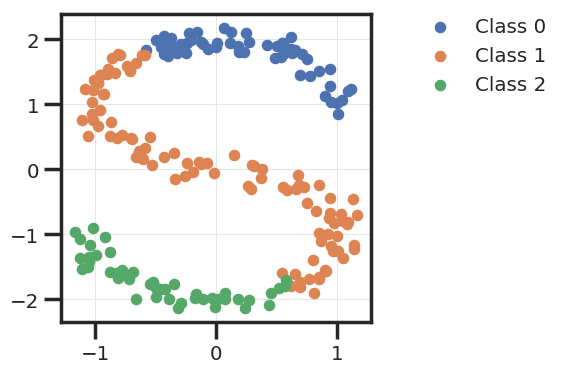

In [ ]:
dataset_S = load_synthetic_data()

In [ ]:
# Define dataloader for the synthetic dataset
xdat = torch.from_numpy(dataset_S['X']).float()
ydat = torch.from_numpy(dataset_S['Y']).long()

data = torch.utils.data.TensorDataset(xdat, ydat)
loader = torch.utils.data.DataLoader(data, batch_size=4, shuffle=True)

if GPU:
    xdat = xdat.cuda()

We would like to understand the training trajectory of a 2-layer fully-connected network on this synthetic dataset. To study the training trajectory, we could record the weights of the network periodically with the trajectory denoted by $(w_1, w_2, \cdots, w_T)$. This problem is non-convex in the weights making it hard to analyze the trajectories in weight space. 

We instead think of each model in terms of its outputs on a fixed set of inputs $\{x_i\}_{i=1}^N$. We represent each network with weights $w$ as a point $P_w$ in *prediction space* where
$$P_w = \begin{bmatrix}
    p_w(y=1 \mid x_1) & p_w(y=2 \mid x_1) & \cdots \cdots & p_w(y=C \mid x_1) \\
    p_w(y=1 \mid x_2) & p_w(y=2 \mid x_2) & \cdots \cdots & p_w(y=C \mid x_2) \\
    \vdots & \vdots & & \vdots \\
    p_w(y=1 \mid x_N) & p_w(y=2 \mid x_N) & \cdots \cdots & p_w(y=C \mid x_N)
\end{bmatrix}.$$

The prediction vector $P_w$ is an object of size $N \times C$; It contains the predicted output probabilities over the $C$ classes, on each of the $N$ samples.Instead of looking at the sequence $(w_1, \cdots w_T)$, we will instead study the sequence $(P_{w_1}, P_{w_2}, \cdots P_{w_T})$. 


We record the sequence of $P_w$ at T=62 points during training on the synthetic dataset. We train 10 fully-connected networks from different random initializations (seeds) which gives us 10 trajectories in total. 

In [ ]:
def get_synthetic_data_predictions(seed):
    """
    Train a neural network on synthetic data and record the predictions 
    at periodic intervals
    """
    set_seed(seed)
    net = MLP(input_size=2, 
              hidden=[500, 500],
              num_classes=3).to(DEV)
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01,
                                momentum=0.9, nesterov=True)
    criterion = nn.CrossEntropyLoss()

    preds_list = []
    for ep in range(5):
        for idx, (x, y) in enumerate(loader):
            
            # Log predictions on entire dataset
            if (ep == 0) or (idx % 20 == 0):
                probs = F.softmax(net(xdat), dim=1)
                if GPU:
                    probs = probs.cpu()
                preds_list.append(probs.detach().numpy())

            # Update parameters with gradient descent
            update_mlp_params(x, y, net, optimizer, criterion)

    return np.array(preds_list)

In [ ]:
# Record predictions for 10 trajectories
all_preds = []
for sd in range(10):
    all_preds.append(get_synthetic_data_predictions(sd))
all_preds = np.array(all_preds)
print(all_preds.shape)

(10, 62, 200, 3)


`all_preds` is a np.array of size `[seeds x T x N x C]` and contains the prediction vectors ($P_w$) of 620 models, where each model is represented by a prediction vector of size 600 ($N \times C$). 

But do we really need 600 dimensions to represent each model? Principal component analysis (PCA) reveals that the sequence of prediction vectors are effectively low-dimensional. Just 5 dimensions preserve 94% of the explained variance! 

Explained variance of the first 5 dimensions is 93.63%


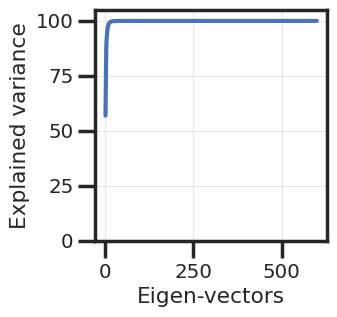

In [ ]:
model_predictions = all_preds.reshape(620, 600)

pca = PCA()
pca.fit(model_predictions)

top5 = np.sum(pca.explained_variance_ratio_[0:5]) * 100
print("Explained variance of the first 5 dimensions is %.2f%%" % top5)

plot_explained_variance(pca.explained_variance_ratio_)

We will see that the prediction vectors of trajectories are effectively low-dimensional even if we change hyper-parameters, architecture, optimizer. But it doesn't end there! It is also low-dimensional if we change the training dataset or train using just unlabeled data. 🤯

We do not have theory to explain why the trajectories are low-dimensional. But understanding this phenomenon may be integral to understanding why neural networks generalize well despite being seemingly high-dimensional objects.

We would like to study the prediction space formally and the next section explains some of the tools that we develop for this purpose. We employ some neat constructions based on Information geometry to study the trajectories of representations. For example, the square root of the predictions $\sqrt{P_w(. \mid x_i)}$ lies on the surface of the sphere. This may seem like a peculiar coordinate transformation but it turns out that the shortest path (geodesic) on the surface of the sphere is exactly the shortest path in another manifold (the latter can be hard to compute). 

In [ ]:
sqrt_pred_sample = np.sqrt(all_preds[:, :, 0]).reshape(-1, 3)

xs = sqrt_pred_sample[:, 0]
ys = sqrt_pred_sample[:, 1]
zs = sqrt_pred_sample[:, 2]

plot_sphere(xs, ys, zs)

# Building a picture of the space of tasks

In this work:

> we build techniques to study the training trajectories of networks when trained using different tasks (say ImageNet vs. iNaturalist) and using different methods (constrastive learning vs. supervised learning).

We introduce the techniques by studying trajectories taken by networks on two tasks--- CIFAR100-A and CIFAR100-B --- which are subsets of the CIFAR100 dataset.

## Imprinting helps us compare models trained on different tasks


The first step is to train a network on each task and record the predictions made by the network during training. But we already have a problem. We would like to understand the networks by studying the object $P_w$ but CIFAR100-A and CIFAR100-B are trained on different sets of classes and hence the predictions are defined on completely different spaces. Our solution to this problem is imprinting. 


Consider a neural network with weights $w = [u, v]$ where
$$P_w(. \mid x) = \psi_v \circ \phi_u(x).$$
The network consists of a function $\phi$ which is the internal representation which is followed by a linear layer $\psi$. **Imprinting replaces the linear layer $\psi_v$ with a different one that makes the model predict on some shared output space.**

In order to embed $w_a$ trained on CIFAR100-A and $w_b$ trained on CIFAR100-B in the same prediction space, we retrain $\psi_{v_a}$ and $\psi_{v_b}$ and force the modified networks to predict on the entirety of CIFAR100. This allows us to study how similar the internal representations of two networks are regardless of which dataset they are trained on. 

In [ ]:
#@title Get imprinted predictions
def train(task=0, seed=0):
    print("Training on task%s with seed %d" % (chr(65+task), seed))
    set_seed(seed)
    arch = WideResnet(50, 16, 4)
    net = torch.compile(arch)
    if GPU:
        net.cuda()

    optimizer = torch.optim.SGD(net.parameters(), lr=0.01,
                                momentum=0.9, nesterov=True)

    criterion = nn.CrossEntropyLoss()
    scaler = torch.cuda.amp.GradScaler()
    dataloader = get_task_dataloader(task)
    test_cifar_loader = get_cifar_dataloader()

    # Train network with mixed precision
    all_preds = []
    for ep in tqdm(range(25)):
        for i, data in enumerate(dataloader):
            if i == 0 or (i % 40 == 0 and ep < 2):
                imprinted_wts = imprint(net, test_cifar_loader)
                all_preds.append(evaluate(net, test_cifar_loader, imprinted_wts))

            update_grad_descent(net, data, optimizer, criterion, scaler)
    all_preds = np.array(all_preds)

    return all_preds

def get_cifar100_preds():
    task_preds = []
    for i in range(2):
        all_preds = []
        for seed in range(3):
            preds = train(i, seed)
            all_preds.append(preds)

        task_preds.append(np.array(all_preds))
    
    return task_preds

We train the networks on CIFAR100-A and CIFAR100-B respectively and record the imprinted predictions on the entire CIFAR100 test dataset. Training these networks take about 15 minutes so we will load the pre-computed predictions from a file.

In [ ]:
preds = {}
preds['taskA'] = np.load("taskA_preds.npy")
preds['taskB'] = np.load("taskB_preds.npy")

# This takes around 20 mins with a GPU, Instead we will load the predictions from a file
# ret_preds = get_cifar100_preds()
# preds['taskA'] = ret_preds[0]
# preds['taskB'] = ret_preds[1]

## InPCA embedding

We use InPCA to build a qualitative picture of the prediction space. These techniques reveal that the trajectories span a low-dimensional manifold in prediction space.

Each prediction vector $P_w$ defines a probabilistic model over the $N$ samples. Hence, the KL-divergence or the Bhattacharyya divergence ($d_B$) define natural ways to measure the distance between two probabilistic models. 
$$ d_B(P_{w_1}, P_{w_2}) = -\frac{1}{N} \sum_{i=1}^N \log \left(\sum_{c} \sqrt{P_{w_1}(y=c \mid x_i) P_{w_2}(y=c \mid x_i)} \right)$$. 


In order to find a low-dimensional embedding for a collection of trajectories we use Intensive-PCA (InPCA). This dimensionality reduction method finds an embedding that preserves the pairwise Bhattacharyya distance between all pairs of models.

In [ ]:
def bhattacharyya_distance_matrix(mat):
    """
    Takes a collection of models and computes the pairwise 
    Bhattacharyya distance between all pairs of models.
    """
    mat = np.sqrt(mat) + 1e-9
    mat1 = np.transpose(mat, axes=[1, 0, 2])
    mat2 = np.transpose(mat, axes=[1, 2, 0])

    Dmat = 0.0
    dim = len(mat1)
    batch = 500

    # Compute distance in batches to avoid OOM 
    for i in range(0, dim, batch):
        Dmat += (np.log(mat1[i:i+batch] @ mat2[i:i+batch])).sum(0)
    Dmat = Dmat / dim
    return Dmat


def compute_inpca(Dmat):
    """
    Compute the InPCA embedding from a pairwise distance matrix
    """
    # Double center matrix
    ldim = Dmat.shape[0]
    Pmat = np.eye(ldim) - 1.0/ ldim
    Wmat = (Pmat @ Dmat @ Pmat) / 2

    eigenval, eigenvec = np.linalg.eigh(Wmat)

    #Sort eigen-values by magnitude
    sort_ind = np.argsort(-np.abs(eigenval))
    eigenval = eigenval[sort_ind]
    eigenvec = eigenvec[:, sort_ind]
    sqrt_eigenval = np.sqrt(np.abs(eigenval))

    # Find projections
    projection = eigenvec * sqrt_eigenval.reshape(1, -1)

    return eigenval, projection

In [ ]:
# Concatenate all the predictions
predictions = np.concatenate([preds['taskA'].reshape(-1, 5000, 100),
                              preds['taskB'].reshape(-1, 5000, 100)], axis=0)

# Compute InPCA embedding of all models
distance_matrix = bhattacharyya_distance_matrix(predictions)
eigenval, embed = compute_inpca(distance_matrix)
embed = embed.reshape([2, 3, 37, -1])

print(predictions.shape)

(222, 5000, 100)


The explained stress measures what fraction of distances that are preserved by the first $k$ dimensions of the embedding. Like we saw in the synthetic dataset, the manifold of predictions is effectively low-dimensional and very few dimensions capture most of the stress. 

Nearly 5 dimensions capture 85% of the stress even though the predicton vector is of size $5 \times 10^5$ (size is $N \times C$). We see that the trajectories continue to be effectively low-dimensional even if we consider a dataset as larger as ImageNet.

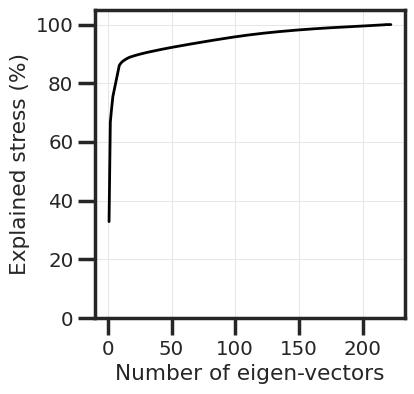

In [ ]:
# Explained stress
eig_sq = (eigenval)**2
eig_sq = eig_sq / np.sum(eig_sq)
expl_stress = np.concatenate([[0], np.cumsum(eig_sq)])
expl_stress = 1 - np.sqrt(1 - np.clip(expl_stress, 0,1)) 
expl_stress *= 100

plot_explained_stress(expl_stress)

We next plot the first 3 dimensions of the InPCA embedding. Both models start at the same point $P_0$ (for all samples, $p(y) = 1/C$) probability for each class) and share the initial parts of the trajectory. This is surprising considering that they are trained on a completely disjoint set of classes. We do not expect this to occur unless different tasks share some underlying structure.

In [ ]:
plot_inpca(embed)

## Computational Information Geometry

We next, build some tools to quantitatively understand the training trajectories in the prediction space.

### Geometric Progress

Most randomly initialized models start at ignorance $P_0$--which predicts a probability of $\frac{1}{C}$ for all classes on every sample. We would like to train these models to $P_*$ (probability 1 for true label) which is a model that minimizes the test loss.

We compute the geometric progress for each point in the trajectory with respect to the geodesic joining $P_0$ and $P_*$. The progress increases monotonically which means that training on a subset of CIFAR100 makes progress on the entire CIFAR100 task.

In [ ]:
def interpolate(start, end, t):
    """
    - Get a point on the geodesic joining "start" and "end". 
    - The geodesic is the same as the geodesic on the surface of a sphere
      which is the great cirlce equation
    """
    cospq = (start * end).sum(-1, keepdims=True)
    dg = np.arccos(np.clip(cospq, 0, 1))

    # Use masks, incase, start and end are identical
    mask = (dg <= 1e-6).reshape(-1)
    gamma = np.array(start)
    gamma[~mask] = np.sin((1-t)* dg[~mask]) * start[~mask] + \
                   np.sin(t    * dg[~mask]) * end[~mask]
    gamma[~mask] = gamma[~mask] / np.sin(dg[~mask])

    return gamma


def project(traj, start, end):
    """
    - Computes the progress (λ) for each model in the trajectory.
    - Progress is a scalar that belongs to the set [0, 1].
    - It measures how far the model is along the geodesic
      joining 'start' and 'end'.
    """
    def dB(t, n=0):
        vec = interpolate(start, end, t)
        dist = (-np.log((vec * traj[n]).sum(-1))).sum()
        return dist

    lam = []
    for ep in range(len(traj)):
        dn = partial(dB, n=ep)
        # Find the point on the geodesic with smallest distance
        # to the model. This corresponds to the geometric progress. 
        l = optimize.minimize_scalar(dn, bounds=(0, 1), method='bounded').x
        lam.append(float(l))

    return lam

In [ ]:
def get_progress(trajectory, p_0, p_star):
    targets = np.argmax(p_star, axis=1)
    prog_list = []
    acc_list = []
    for ep in range(len(trajectory)):
        preds = np.argmax(trajectory[ep], axis=1)
        prog = project([np.sqrt(trajectory[ep])], p_0, p_star)[0]

        acc = np.sum(preds == targets) / len(targets)
        
        prog_list.append(prog)
        acc_list.append(acc)
        
    return prog_list

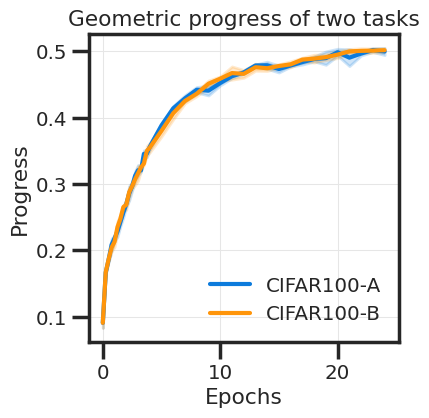

In [ ]:
progress = {}
p_0, p_star = cifar100_start_end()

for i, task_pred in enumerate([preds['taskA'], preds['taskB']]):
    prog_mat = []
    for seed in range(task_pred.shape[0]):
        prog = get_progress(task_pred[seed], p_0, p_star)
        prog_mat.append(prog)
        
    progress['task{}'.format(chr(65+i))] = np.array(prog_mat)

plot_progress(progress)   

### Reindexing trajectories with progress

Let two trajectories be denoted by $(P_{w_1}, \cdots, P_{w_T})$ and $(P_{u_1}, \cdots, P_{u_T})$. We could compare the two trajectories with a pairwise comparison of the models at different time-steps. However, this comparison is flawed, since "epoch" does not serve as a reliable notion of time (see paper for more details).

We hence use geometric progress to index trajectories and it serves as our notion of time. Given any value of $s \in [0, 1]$, `sample_trajectory` will return a model that corresponds to a progress of $s$ along the geodesic joining $P_0$ and $P_*$. 

In [ ]:
def sample_trajectory(traj, λ_true, λ_sample):
    """
    Sample from the parameterized trajectory
    """
    ind = 0
    max_ind = len(λ_true)

    samples = []

    for λ in λ_sample:

        # Find first λ_true (from left) bigger than λ
        while ind < max_ind:
            if λ_true[ind] > λ:
                break;
            ind += 1

        # Draw sample
        if ind == max_ind:
            sample = traj[-1]
        elif ind == 0:
            sample = traj[0]
        else:
            seg_start = traj[ind - 1]
            seg_end = traj[ind]

            λ_start = λ_true[ind-1]
            λ_end = λ_true[ind]
            assert(λ_start <= λ and λ_end >= λ)

            λ_segment = (λ - λ_start) / (λ_end - λ_start)
            λ_segment = np.clip(λ_segment, 0, 1)
            sample = interpolate(seg_start, seg_end, λ_segment)

        samples.append(sample)

    samples = np.array(samples)
    return samples

In [ ]:
pmin = np.min(progress['taskA'])
pmax = np.max(progress['taskB'])

prog_sample = np.arange(pmin, pmax, 0.01)

preds_reindexed = {}

for task in progress:
    preds_new = []
    for seed, prog_true in enumerate(progress[task]):
        pnew = sample_trajectory(preds[task][seed], prog_true, prog_sample)
        preds_new.append(pnew)
        
    preds_reindexed[task] = np.array(preds_new)

### Comparing trajectories

After reindexing the trajectories using progress, we can reliably compare two trajectories at different values of progress. We can us ethis to quantify how similar two trajectories are in prediction space. The plot indicates that that the trajectories of CIFAR100-A and CIFAR100-B are different both initially and towards the end of training.

In [ ]:
avg_predsA = preds_reindexed['taskA'].mean(0)
avg_predsB = preds_reindexed['taskB'].mean(0)
dist = (-np.log(1e-9 + (avg_predsA * avg_predsB).sum(-1)).mean(-1))

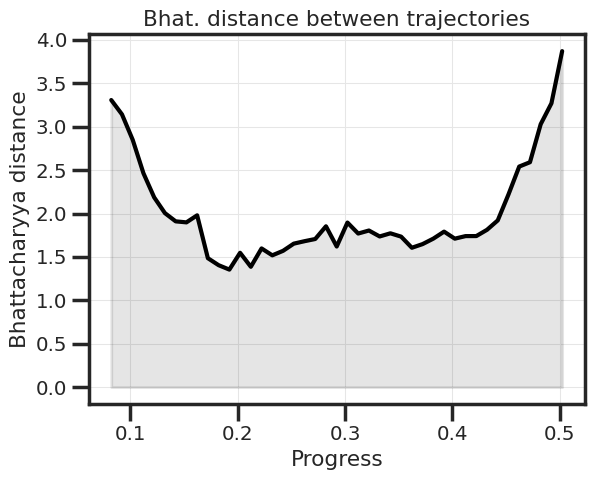

In [ ]:
plot_trajectory_distance(prog_sample, dist)

### Computing the Reimann Length of a trajectory

Finally, we can compute the Reimann lengths of the trajectory. In our work, we use this to show that episodic meta-learning trajectories are 10-40x longer than supervised learning but they eventually end at the same point in prediction space. The Reimann length could be used as a measure of inefficiency of the training process.

In [ ]:
def reimann_length(trajectory):
    dist = (-np.log(1e-9 + (trajectory[:-1] * trajectory[1:]).sum(-1)).mean(-1))
    length = (2 * np.sqrt(dist).sum(-1))
    return length.mean(), length.std()

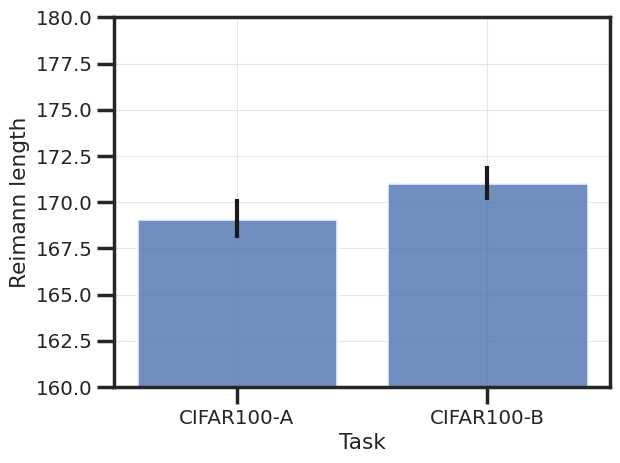

In [ ]:
lenA = reimann_length(preds['taskA'])
lenB = reimann_length(preds['taskB'])
plot_reimann_length(lenA, lenB)

This concludes this mini-tutorial that introduces all the tools developed in our work. These tools are very general: they allow us to compare very different methods and trajectories of models trained on different datasets. We point these tools towards understanding phenomena relating to pre-training, episodic meta-learning, contrastive learning and fine-tuning. By shedding light on some interesting phenomena, we hope to improve our understanding of the geometric structure of the space of tasks. 😃